In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import copy
import warnings

import scipy
import scipy.integrate as integrate

import numpy as np 

from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table, Column, vstack

import matplotlib.pyplot as plt

In [2]:
import sedpy
import extinction

In [3]:
from sedpy import observate
from sedpy import reference_spectra

In [4]:
from caterpillar import extinction as catext

#### HSC Calibration

In [5]:
hsc_rb = [3.240, 2.276, 1.633, 1.263, 1.075]
hsc_filters = ['hsc_g', 'hsc_r', 'hsc_i', 'hsc_z', 'hsc_y']
hsc_dir = '/Users/song/Dropbox/work/project/caterpillar/data/filters/hsc/'

#### DECam Calibration

In [6]:
decam_rb = [3.994, 3.212, 2.164, 1.591, 1.211, 1.063]
decam_filters = ['decam_u', 'decam_g', 'decam_r', 'decam_i', 'decam_z', 'decam_y']

#### SDSS Calibration

In [7]:
sdss_rb = [4.239, 3.303, 2.285, 1.698, 1.263]
sdss_filters = ['sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'sdss_z0']

#### Reference spectra of synthetic stars

- Following Schlafly & Finkbeiner (2011):
    - "For the source spectrum, we use for S(λ) a synthetic spectrum from [Munari et al. (2005)](https://www.aanda.org/articles/aa/pdf/2005/42/aa2490-04.pdf), with Teff = 7000 K, logZ = −1, and log g = 4.5."

In [8]:
star_ref = Table.read('../../data/stellar/munari2005_t7000_g45_m10.txt', format='ascii')
star_wave, star_flux = star_ref['col1'], star_ref['col2']

star = {'wave': star_wave, 'flux': star_flux}

#### Reference Solar spectrum

In [9]:
solar = reference_spectra.solar
solar_wave, solar_flux = solar[:, 0], solar[:, 1]

flag = (solar_wave >= 2500.) & (solar_wave <= 15000)
solar_wave, solar_flux = solar_wave[flag], solar_flux[flag]

solar = {'wave': solar_wave, 'flux': solar_flux}

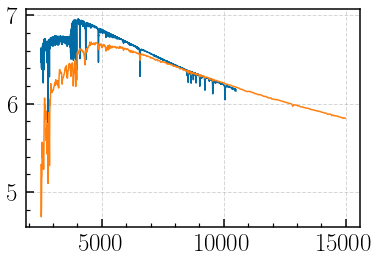

In [10]:
plt.plot(star_wave, np.log10(star_flux))
plt.plot(solar_wave, np.log10(solar_flux) + 17)

### Calibration

- $\Delta m_{b}=-2.5 \log \left[\frac{\int d \lambda W_{b}(\lambda) S(\lambda) 10^{-A(\lambda) \Delta m_{1 \mu \mathrm{m}} / 2.5}}{\int d \lambda W_{b}(\lambda) S(\lambda)}\right]$

- extinction = E(B-V) x Coefficient.

- https://github.com/schlafly/dust/blob/master/python/dust.py
- https://github.com/schlafly/specfilt

In [11]:
for r, f in zip(sdss_rb, sdss_filters):
    r_f = catext.get_extinction_coefficient(f, star, A_V=1.0, R_V=3.1) 
    print("{:5.3f} {:5.3f} {:5.3f}%".format(r_f, r, ((r_f - r) / r) * 100.0))

4.258 4.239 0.447%
3.306 3.303 0.096%
2.294 2.285 0.373%
1.704 1.698 0.355%
1.270 1.263 0.522%


/Users/song/Dropbox/work/project/caterpillar/caterpillar/extinction.py:28: UserWarning: # Reference spectrum does not cover the filter!
  warnings.warn("# Reference spectrum does not cover the filter!")


In [12]:
for r, f in zip(decam_rb, decam_filters):
    r_f = catext.get_extinction_coefficient(f, star, A_V=1.0, R_V=3.1) 
    print("{:5.3f} {:5.3f} {:5.3f}%".format(r_f, r, ((r_f - r) / r) * 100.0))

4.038 3.994 1.105%
3.218 3.212 0.191%
2.170 2.164 0.280%
1.593 1.591 0.099%
1.211 1.211 -0.020%
1.060 1.063 -0.310%


In [13]:
for r, f in zip(hsc_rb, hsc_filters):
    r_f = catext.get_extinction_coefficient(f, star, A_V=1.0, R_V=3.1, filter_dir=hsc_dir) 
    print("{:5.3f} {:5.3f} {:5.3f}%".format(r_f, r, ((r_f - r) / r) * 100.0))

3.234 3.240 -0.195%
2.277 2.276 0.031%
1.637 1.633 0.247%
1.268 1.263 0.424%
1.084 1.075 0.842%


### For Merian filter

#### N708 filter

In [19]:
merian_filters = ['merian_n708_avg', 'merian_n708_med']
merian_dir = '/Users/song/Dropbox/work/project/caterpillar/data/filters/merian/'

In [20]:
for f in merian_filters:
    print(catext.get_extinction_coefficient(f, star, A_V=1.0, R_V=3.1, filter_dir=merian_dir))
    print(catext.get_extinction_coefficient(f, solar, A_V=1.0, R_V=3.1, filter_dir=merian_dir))

1.8472855726474002
1.847156535768398
1.8481197197521055
1.8479742080681112


In [23]:
merian_n708 = ["merian_n708_{:d}".format(ii + 1) for ii in np.arange(49)]

In [25]:
np.nanstd([
    catext.get_extinction_coefficient(f, star, A_V=1.0, R_V=3.1, filter_dir=os.path.join(merian_dir, 'n708')) 
    for f in merian_n708])

0.0024207455121428197

#### N540 filter

In [14]:
merian_filters = ['merian_n540_avg', 'merian_n540_med']
merian_dir = '/Users/song/Dropbox/work/project/caterpillar/data/filters/merian/'

In [15]:
for f in merian_filters:
    print(catext.get_extinction_coefficient(f, star, A_V=1.0, R_V=3.1, filter_dir=merian_dir))
    print(catext.get_extinction_coefficient(f, solar, A_V=1.0, R_V=3.1, filter_dir=merian_dir))

2.7538322752021656
2.753078718147269
2.7533775737094617
2.7526143735877726


In [16]:
merian_n540 = ["merian_n540_{:d}".format(ii + 1) for ii in np.arange(49)]

In [17]:
np.nanstd([
    catext.get_extinction_coefficient(f, star, A_V=1.0, R_V=3.1, filter_dir=os.path.join(merian_dir, 'n540')) 
    for f in merian_n540])

0.0025199452259448245